In [1]:
# Import the required libraries
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
import ta
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout

%matplotlib inline

In [2]:
# Read csv, take a look
aapl_df = pd.read_csv(
    Path('signals_returns_appl.csv'),
    index_col="Date",
    infer_datetime_format=True, 
    parse_dates=True)
aapl_df

C:\Users\amanl\AppData\Local\Temp\ipykernel_6868\506033898.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  aapl_df = pd.read_csv(


,Open,High,Low,Close,Adj Close,Volume,isPivot,Return,signal
Date,,,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.152657,135480400,0,0.0,0.0
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.441467,146322800,0,0.0,0.0
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.018684,118387200,0,0.0,0.0
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.675270,108872000,0,0.0,0.0
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.844360,132079200,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2024-01-12,186.059998,186.740005,185.190002,185.919998,185.919998,40444700,0,0.0,0.0
2024-01-16,182.160004,184.259995,180.929993,183.630005,183.630005,65603000,0,0.0,0.0
2024-01-17,181.270004,182.929993,180.300003,182.679993,182.679993,47317400,0,0.0,0.0


In [3]:
# Calculate the MACD and signal line using talib
aapl_df['macd']= ta.trend.MACD(aapl_df['Close']).macd()
aapl_df['macd signal']= ta.trend.MACD(aapl_df['Close']).macd_signal()

# Calculate the RSI using talib
aapl_df['rsi'] = ta.momentum.RSIIndicator(aapl_df['Close']).rsi()

#Moving averages short and long
aapl_df['ma 30']= aapl_df['Close'].rolling(window=30).mean()
aapl_df['ma 200']=aapl_df['Close'].rolling(window=200).mean()

# Volume related indicator
aapl_df['Volume sma']=aapl_df['Volume'].rolling(window=20).mean()

# Support and resistance levels
aapl_df['support level']=aapl_df['Low'].rolling(window=50).min()
aapl_df['resistance level']=aapl_df['High'].rolling(window=50).max()

# Aweseome Oscillator
aapl_df['Median_Price'] = (aapl_df['High'] + aapl_df['Low']) / 2
aapl_df['SMA5'] = aapl_df['Median_Price'].rolling(window=5).mean()
aapl_df['SMA34'] = aapl_df['Median_Price'].rolling(window=34).mean()
aapl_df['Awesome_Oscillator'] = aapl_df['SMA5'] - aapl_df['SMA34']

# Chaikin Money FLow Indicator
cmf_indicator = ta.volume.ChaikinMoneyFlowIndicator(high=aapl_df['High'], low=aapl_df['Low'], close=aapl_df['Close'], volume=aapl_df['Volume'], window=20)
aapl_df['Chaikin_Money_Flow'] = cmf_indicator.chaikin_money_flow()

#ATR (Average True Range)
atr = ta.volatility.AverageTrueRange(high=aapl_df['High'], low=aapl_df['Low'], close=aapl_df['Close'], window=14)
aapl_df['ATR'] = atr.average_true_range()

# Bollinger Bands
bollinger_bands= ta.volatility.BollingerBands(close=aapl_df['Close'], window=20, window_dev=1)
aapl_df['BB_Middle'] = bollinger_bands.bollinger_mavg()  # Middle band (SMA)
aapl_df['BB_Upper'] = bollinger_bands.bollinger_hband()  # Upper band
aapl_df['BB_Lower'] = bollinger_bands.bollinger_lband()  # Lower band

# Stochastic Oscillator
stochastic_oscillator = ta.momentum.StochasticOscillator(high=aapl_df['High'], low=aapl_df['Low'], close=aapl_df['Close'], window=14, smooth_window=3)
aapl_df['%K'] = stochastic_oscillator.stoch()
aapl_df['%D'] = stochastic_oscillator.stoch_signal()

# CCI (Commodity Channel Index)
cci_indicator = ta.trend.CCIIndicator(high=aapl_df['High'], low=aapl_df['Low'], close=aapl_df['Close'], window=20)
aapl_df['CCI'] = cci_indicator.cci()

# Parabolic SAR (Stop and Reverse)
psar_indicator = ta.trend.PSARIndicator(high=aapl_df['High'], low=aapl_df['Low'], close=aapl_df['Close'])
aapl_df['PSAR'] = psar_indicator.psar()

#Ichimoku Cloud
conversion_line_period = 9
base_line_period = 26
lagging_span_period = 52
conversion_line = (aapl_df['High'].rolling(window=conversion_line_period).max() + aapl_df['Low'].rolling(window=conversion_line_period).min()) / 2
base_line = (aapl_df['High'].rolling(window=base_line_period).max() + aapl_df['Low'].rolling(window=base_line_period).min()) / 2
leading_span_a = (conversion_line + base_line) / 2
leading_span_b = (aapl_df['High'].rolling(window=lagging_span_period).max() + aapl_df['Low'].rolling(window=lagging_span_period).min()) / 2
lagging_span = aapl_df['Close'].shift(-lagging_span_period)

aapl_df['Ichimoku_Conversion_Line'] = conversion_line
aapl_df['Ichimoku_Base_Line'] = base_line
aapl_df['Ichimoku_Leading_Span_A'] = leading_span_a
aapl_df['Ichimoku_Leading_Span_B'] = leading_span_b
aapl_df['Ichimoku_Lagging_Span'] = lagging_span

# Williams %R

williams_r_indicator = ta.momentum.WilliamsRIndicator(high=aapl_df['High'], low=aapl_df['Low'], close=aapl_df['Close'], lbp=14)
aapl_df['Williams_%R'] = williams_r_indicator.williams_r()

# Volume Weighted Average Price (VWAP)
obv_indicator = ta.volume.OnBalanceVolumeIndicator(close=aapl_df['Close'], volume=aapl_df['Volume'])
aapl_df['On_Balance_Volume'] = obv_indicator.on_balance_volume()

# On-Balance Volume (OBV)
aapl_df['OBV'] = (aapl_df['Close'].pct_change().fillna(0) > 0).astype(int)
aapl_df['OBV'] = (aapl_df['OBV'] * 2 - 1) * aapl_df['Volume']
aapl_df['OBV'] = aapl_df['OBV'].cumsum()

# Relative Vigor Index (RVI)
aapl_df['Typical_Price'] = (aapl_df['High'] + aapl_df['Low'] + 2 * aapl_df['Close']) / 4
aapl_df['Closing_Price_Change'] = aapl_df['Close'].diff()
aapl_df['RVI'] = aapl_df['Typical_Price'].rolling(window=14).sum() / aapl_df['Closing_Price_Change'].abs().rolling(window=14).sum()

#Aroon Indicator
aroon_indicator = ta.trend.AroonIndicator(high=aapl_df['High'], low=aapl_df['Low'], window=14)
aapl_df['Aroon_Up'] = aroon_indicator.aroon_up()
aapl_df['Aroon_Down'] = aroon_indicator.aroon_down()
aapl_df['Aroon_Oscillator'] = aroon_indicator.aroon_indicator()

#Chaikin Oscillator
aapl_df['ADL'] = ((aapl_df['Close'] - aapl_df['Low']) - (aapl_df['High'] - aapl_df['Close'])) / (aapl_df['High'] - aapl_df['Low']) * aapl_df['Volume']
aapl_df['ADL'] = aapl_df['ADL'].cumsum()
aapl_df['EMA3'] = aapl_df['ADL'].ewm(span=3, adjust=False).mean()
aapl_df['EMA10'] = aapl_df['ADL'].ewm(span=10, adjust=False).mean()
aapl_df['Chaikin_Oscillator'] = aapl_df['EMA3'] - aapl_df['EMA10']

c:\Users\amanl\Anaconda3\envs\dev\lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


In [4]:
aapl_df

,Open,High,Low,Close,Adj Close,Volume,isPivot,Return,signal,macd,...,Typical_Price,Closing_Price_Change,RVI,Aroon_Up,Aroon_Down,Aroon_Oscillator,ADL,EMA3,EMA10,Chaikin_Oscillator
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.152657,135480400,0,0.0,0.0,NaN,...,74.780626,NaN,NaN,NaN,NaN,NaN,1.229591e+08,1.229591e+08,1.229591e+08,0.000000e+00
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.441467,146322800,0,0.0,0.0,NaN,...,74.496248,-0.730003,NaN,NaN,NaN,NaN,4.334199e+07,8.315055e+07,1.084833e+08,-2.533272e+07
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.018684,118387200,0,0.0,0.0,NaN,...,74.519373,0.592499,NaN,NaN,NaN,NaN,1.564747e+08,1.198126e+08,1.172090e+08,2.603642e+06
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.675270,108872000,0,0.0,0.0,NaN,...,74.697502,-0.352493,NaN,NaN,NaN,NaN,1.055410e+08,1.126768e+08,1.150875e+08,-2.410733e+06
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.844360,132079200,0,0.0,0.0,NaN,...,75.498751,1.199997,NaN,NaN,NaN,NaN,1.922633e+08,1.524700e+08,1.291195e+08,2.335056e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-12,186.059998,186.740005,185.190002,185.919998,185.919998,40444700,0,0.0,0.0,-1.610284,...,185.942501,0.330002,123.063077,0.000000,64.285714,-64.285714,5.658403e+09,5.648810e+09,5.608252e+09,4.055800e+07
2024-01-16,182.160004,184.259995,180.929993,183.630005,183.630005,65603000,0,0.0,0.0,-1.755825,...,183.112499,-2.289993,115.981502,0.000000,57.142857,-57.142857,5.699184e+09,5.673997e+09,5.624785e+09,4.921186e+07
2024-01-17,181.270004,182.929993,180.300003,182.679993,182.679993,47317400,0,0.0,0.0,-1.925628,...,182.147495,-0.950012,113.478186,14.285714,50.000000,-35.714286,5.737505e+09,5.705751e+09,5.645280e+09,6.047152e+07


In [5]:
# Drop Nan
aapl_df = aapl_df.dropna()
aapl_df

,Open,High,Low,Close,Adj Close,Volume,isPivot,Return,signal,macd,...,Typical_Price,Closing_Price_Change,RVI,Aroon_Up,Aroon_Down,Aroon_Oscillator,ADL,EMA3,EMA10,Chaikin_Oscillator
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-15,118.720001,121.199997,118.150002,120.709999,118.410858,112559200,0,0.0,0.0,1.690042,...,120.192499,-0.480003,50.894900,85.714286,0.000000,85.714286,2.748948e+09,2.716568e+09,2.658611e+09,5.795735e+07
2020-10-16,121.279999,121.550003,118.809998,119.019997,116.753044,115393800,0,0.0,0.0,1.641793,...,119.599998,-1.690002,52.674271,78.571429,28.571429,50.000000,2.651242e+09,2.683905e+09,2.657271e+09,2.663404e+07
2020-10-19,119.959999,120.419998,115.660004,115.980003,113.770943,120639300,0,0.0,0.0,1.342773,...,117.010002,-3.039993,49.329215,71.428571,21.428571,50.000000,2.546823e+09,2.615364e+09,2.637190e+09,-2.182551e+07
2020-10-20,116.199997,118.980003,115.629997,117.510002,115.271797,124423700,0,0.0,0.0,1.215248,...,117.407501,1.529999,49.665620,64.285714,14.285714,50.000000,2.562051e+09,2.588708e+09,2.623528e+09,-3.482043e+07
2020-10-21,116.669998,118.709999,116.449997,116.870003,114.643990,89946000,0,0.0,0.0,1.050432,...,117.225000,-0.639999,50.193621,57.142857,7.142857,50.000000,2.505537e+09,2.547122e+09,2.602075e+09,-5.495287e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-27,166.910004,168.960007,166.830002,168.220001,167.998672,58499100,0,0.0,0.0,-1.934634,...,168.057503,1.330002,127.744411,21.428571,92.857143,-71.428571,5.000408e+09,5.004240e+09,5.026697e+09,-2.245714e+07
2023-10-30,169.020004,171.169998,168.869995,170.289993,170.065933,51131000,0,0.0,0.0,-1.986250,...,170.154995,2.069992,118.245865,14.285714,85.714286,-71.428571,5.012412e+09,5.008326e+09,5.024100e+09,-1.577380e+07
2023-10-31,169.350006,170.899994,167.899994,170.770004,170.545319,44846000,0,0.0,0.0,-1.965762,...,170.084999,0.480011,123.354341,7.142857,78.571429,-71.428571,5.053372e+09,5.030849e+09,5.029422e+09,1.426895e+06


In [6]:
aapl_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 768 entries, 2020-10-15 to 2023-11-02
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Open                      768 non-null    float64
 1   High                      768 non-null    float64
 2   Low                       768 non-null    float64
 3   Close                     768 non-null    float64
 4   Adj Close                 768 non-null    float64
 5   Volume                    768 non-null    int64  
 6   isPivot                   768 non-null    int64  
 7   Return                    768 non-null    float64
 8   signal                    768 non-null    float64
 9   macd                      768 non-null    float64
 10  macd signal               768 non-null    float64
 11  rsi                       768 non-null    float64
 12  ma 30                     768 non-null    float64
 13  ma 200                    768 non-null    floa

In [7]:
# Get column names
column_names = aapl_df.columns

# Display column names
print("Column Names:", column_names)

Column Names: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'isPivot',
       'Return', 'signal', 'macd', 'macd signal', 'rsi', 'ma 30', 'ma 200',
       'Volume sma', 'support level', 'resistance level', 'Median_Price',
       'SMA5', 'SMA34', 'Awesome_Oscillator', 'Chaikin_Money_Flow', 'ATR',
       'BB_Middle', 'BB_Upper', 'BB_Lower', '%K', '%D', 'CCI', 'PSAR',
       'Ichimoku_Conversion_Line', 'Ichimoku_Base_Line',
       'Ichimoku_Leading_Span_A', 'Ichimoku_Leading_Span_B',
       'Ichimoku_Lagging_Span', 'Williams_%R', 'On_Balance_Volume', 'OBV',
       'Typical_Price', 'Closing_Price_Change', 'RVI', 'Aroon_Up',
       'Aroon_Down', 'Aroon_Oscillator', 'ADL', 'EMA3', 'EMA10',
       'Chaikin_Oscillator'],
      dtype='object')


In [8]:
# Assign a copy of the columns except isPivot and signal to a new DataFrame called `X`
X = aapl_df[column_names].shift().dropna().copy()

# Display sample data
display(X.head())
display(X.tail())

,Open,High,Low,Close,Adj Close,Volume,isPivot,Return,signal,macd,...,Typical_Price,Closing_Price_Change,RVI,Aroon_Up,Aroon_Down,Aroon_Oscillator,ADL,EMA3,EMA10,Chaikin_Oscillator
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-16,118.720001,121.199997,118.150002,120.709999,118.410858,112559200.0,0.0,0.0,0.0,1.690042,...,120.192499,-0.480003,50.894900,85.714286,0.000000,85.714286,2.748948e+09,2.716568e+09,2.658611e+09,5.795735e+07
2020-10-19,121.279999,121.550003,118.809998,119.019997,116.753044,115393800.0,0.0,0.0,0.0,1.641793,...,119.599998,-1.690002,52.674271,78.571429,28.571429,50.000000,2.651242e+09,2.683905e+09,2.657271e+09,2.663404e+07
2020-10-20,119.959999,120.419998,115.660004,115.980003,113.770943,120639300.0,0.0,0.0,0.0,1.342773,...,117.010002,-3.039993,49.329215,71.428571,21.428571,50.000000,2.546823e+09,2.615364e+09,2.637190e+09,-2.182551e+07
2020-10-21,116.199997,118.980003,115.629997,117.510002,115.271797,124423700.0,0.0,0.0,0.0,1.215248,...,117.407501,1.529999,49.665620,64.285714,14.285714,50.000000,2.562051e+09,2.588708e+09,2.623528e+09,-3.482043e+07
2020-10-22,116.669998,118.709999,116.449997,116.870003,114.643990,89946000.0,0.0,0.0,0.0,1.050432,...,117.225000,-0.639999,50.193621,57.142857,7.142857,50.000000,2.505537e+09,2.547122e+09,2.602075e+09,-5.495287e+07


,Open,High,Low,Close,Adj Close,Volume,isPivot,Return,signal,macd,...,Typical_Price,Closing_Price_Change,RVI,Aroon_Up,Aroon_Down,Aroon_Oscillator,ADL,EMA3,EMA10,Chaikin_Oscillator
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-27,170.369995,171.380005,165.669998,166.889999,166.670425,70625300.0,-1.0,0.0,1.0,-1.629851,...,167.707500,-4.210007,127.146978,28.571429,100.000000,-71.428571,4.982556e+09,5.008073e+09,5.032539e+09,-2.446689e+07
2023-10-30,166.910004,168.960007,166.830002,168.220001,167.998672,58499100.0,0.0,0.0,0.0,-1.934634,...,168.057503,1.330002,127.744411,21.428571,92.857143,-71.428571,5.000408e+09,5.004240e+09,5.026697e+09,-2.245714e+07
2023-10-31,169.020004,171.169998,168.869995,170.289993,170.065933,51131000.0,0.0,0.0,0.0,-1.986250,...,170.154995,2.069992,118.245865,14.285714,85.714286,-71.428571,5.012412e+09,5.008326e+09,5.024100e+09,-1.577380e+07
2023-11-01,169.350006,170.899994,167.899994,170.770004,170.545319,44846000.0,0.0,0.0,0.0,-1.965762,...,170.084999,0.480011,123.354341,7.142857,78.571429,-71.428571,5.053372e+09,5.030849e+09,5.029422e+09,1.426895e+06
2023-11-02,171.000000,174.229996,170.119995,173.970001,173.741104,56934900.0,0.0,0.0,0.0,-1.672039,...,173.072498,3.199997,110.179588,0.000000,71.428571,-71.428571,5.103104e+09,5.066976e+09,5.042819e+09,2.415752e+07


In [9]:
# Save the signal column as our 'y'
y=aapl_df["signal"].copy()

In [10]:
# Set start of training period
training_begin = X.index.min()
# Display the training begin date
print(training_begin)

2020-10-16 00:00:00


In [11]:
# Select the ending period for the training data with an offset of 18 months
training_end = X.index.min() + DateOffset(months=25)
# Display the training end date
print(training_end)

2022-11-16 00:00:00


In [12]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

In [13]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Using Machine Learning Into a Trading Strategy

In [14]:
# Import the SVM model
from sklearn import svm
from sklearn.metrics import classification_report

In [15]:
# Create the classifier model
svm_model = svm.SVC()

# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [16]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)

# Display report
print("Training Report with indicators")
print(training_report)

Training Report with indicators
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        30
         0.0       0.89      1.00      0.94       466
         1.0       0.00      0.00      0.00        30

    accuracy                           0.89       526
   macro avg       0.30      0.33      0.31       526
weighted avg       0.78      0.89      0.83       526



c:\Users\amanl\Anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amanl\Anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amanl\Anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Backtesting a Machine Learning Trading Algorithm

In [17]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [18]:
# Evaluate the model's ability to predict the trading signal for the testing data
testing_report = classification_report(y_test, testing_signal_predictions)

# Display the report
print("Testing Report with indicators")
print(testing_report)

Testing Report with indicators
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        16
         0.0       0.88      1.00      0.93       212
         1.0       0.00      0.00      0.00        14

    accuracy                           0.88       242
   macro avg       0.29      0.33      0.31       242
weighted avg       0.77      0.88      0.82       242



c:\Users\amanl\Anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amanl\Anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amanl\Anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["Signal"] = aapl_df["signal"]

predictions_df["SVM Signal"] = testing_signal_predictions

predictions_df["Return"] = aapl_df["Return"] * -aapl_df['signal']


predictions_df["SVM Return"] = (
    predictions_df["Return"] * -predictions_df["SVM Signal"]
)

# Review the DataFrame
predictions_df[predictions_df['Signal'] !=0]

,Signal,SVM Signal,Return,SVM Return
Date,,,,
2022-11-29,1.0,0.0,-0.000000,0.0
2022-12-05,-1.0,0.0,8825.943375,-0.0
2022-12-07,1.0,0.0,-0.000000,0.0
2022-12-13,-1.0,0.0,8663.931061,-0.0
2023-01-03,1.0,0.0,-0.000000,0.0
2023-02-03,-1.0,0.0,33674.946808,-0.0
2023-02-16,-1.0,0.0,0.000000,-0.0
2023-03-02,1.0,0.0,-0.000000,0.0
2023-03-06,-1.0,0.0,12300.809082,-0.0


Text(0.5, 1.0, 'Strategy Returns vs SVM Returns With Indicators')

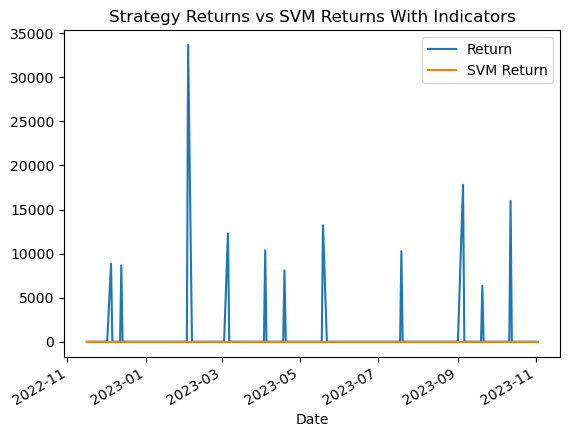

In [20]:
# Plotting the Returns
ax = (predictions_df[["Return", "SVM Return"]]).plot()

# Adding a title
ax.set_title("Strategy Returns vs SVM Returns With Indicators")

## Build a Model

In [21]:
# Define the the number of inputs (features) to the model
number_input_features = len(X_train.iloc[0])

# Define the number of neurons in the output layer
number_output_neurons = 1

# Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1 =  (number_input_features+1)//2

# Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer2 =  (hidden_nodes_layer1+1)//2

# Create the Sequential model instance
nn = Sequential()

# Add the first hidden layer
nn.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Add the second hidden layer
nn.add(Dense(units=hidden_nodes_layer2, activation="relu"))

# Add the output layer to the model specifying the number of output neurons and activation function
nn.add(Dense(units=number_output_neurons, activation="sigmoid"))

# Display the Sequential model summary
nn.summary()

# Compile the Sequential model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model using 50 epochs and the training data
fit_model = nn.fit(X_train_scaled,y_train, 
                    epochs=100,
                    batch_size=25,
                    shuffle=False)

# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)

# Display the model loss and accuracy results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                1176      
                                                                 
 dense_1 (Dense)             (None, 12)                300       
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 1489 (5.82 KB)
Trainable params: 1489 (5.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch 1/100


22/22 [==============================] - 1s 2ms/step - loss: 1.2134 - accuracy: 0.1939
Epoch 2/100
22/22 [==============================] - 0s 1ms/step - loss: 0.7596 - accuracy: 0.5076
Epoch 3/100
22/22 [==============================] - 0s 738us/step - loss: 0.5752 - ac

In [22]:
# Extract predictions from neural network
predictions = nn.predict(X)
#print(predictions)

24/24 [==============================] - 0s 731us/step


In [23]:
# Add Dates and set index
preditions_results = pd.DataFrame(predictions,index=X.index, columns=['NN Signal'])
preditions_results

,NN Signal
Date,
2020-10-16,0.0
2020-10-19,0.0
2020-10-20,0.0
2020-10-21,0.0
2020-10-22,0.0
...,...
2023-10-27,0.0
2023-10-30,0.0
2023-10-31,0.0


In [24]:
# Merge predicted signals and predictions_df to compare results
compare_df = pd.merge(predictions_df, preditions_results, on='Date')
compare_df["NN Return"] = compare_df["NN Signal"] * -compare_df['Return']

compare_df[compare_df['Signal'] != 0]

,Signal,SVM Signal,Return,SVM Return,NN Signal,NN Return
Date,,,,,,
2022-11-29,1.0,0.0,-0.000000,0.0,0.0,0.0
2022-12-05,-1.0,0.0,8825.943375,-0.0,0.0,-0.0
2022-12-07,1.0,0.0,-0.000000,0.0,0.0,0.0
2022-12-13,-1.0,0.0,8663.931061,-0.0,0.0,-0.0
2023-01-03,1.0,0.0,-0.000000,0.0,0.0,0.0
2023-02-03,-1.0,0.0,33674.946808,-0.0,0.0,-0.0
2023-02-16,-1.0,0.0,0.000000,-0.0,0.0,-0.0
2023-03-02,1.0,0.0,-0.000000,0.0,0.0,0.0
2023-03-06,-1.0,0.0,12300.809082,-0.0,0.0,-0.0


Text(0.5, 1.0, 'Strategy Returns vs NN Returns With Indicators')

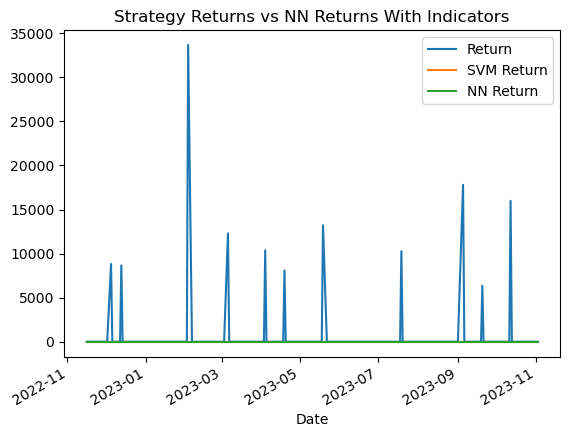

In [31]:
# Plotting the Returns
ax2 = (compare_df[["Return", "SVM Return", "NN Return"]]).plot()

# Adding a title
ax2.set_title("Strategy Returns vs NN Returns With Indicators")

In [26]:
# Make second neural network

# Define the the number of inputs (features) to the model
number_input_features = len(X_train.iloc[0])

# Review the number of features
number_input_features

# Define the number of neurons in the output layer
number_output_neurons = 1

# Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1_2 =  (number_input_features+1)//2

# Review the number hidden nodes in the first layer
hidden_nodes_layer1_2

# Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer2_2 =  (hidden_nodes_layer1+1)//2

# Review the number hidden nodes in the second layer
hidden_nodes_layer2_2

# Define the number of hidden nodes for the third hidden layer
hidden_nodes_layer3_2 =  (hidden_nodes_layer2+1)//2

# Review the number hidden nodes in the third layer
hidden_nodes_layer3_2

# Create the Sequential model instance
nn_2 = Sequential()

# Add the first hidden layer
nn_2.add(Dense(units=hidden_nodes_layer1_2, input_dim=number_input_features, activation="sigmoid"))

# Add the second hidden layer
nn_2.add(Dense(units=hidden_nodes_layer2_2, activation="sigmoid"))

# Add the third hidden layer
nn_2.add(Dense(units=hidden_nodes_layer3_2, activation="sigmoid"))

# Add the output layer to the model specifying the number of output neurons and activation function
nn_2.add(Dense(units=number_output_neurons, activation="sigmoid"))

# Display the Sequential model summary
nn_2.summary()

# Compile the Sequential model
nn_2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


# Fit the model using 100 epochs and the training data
fit_model_2 = nn_2.fit(X_train_scaled, y_train, epochs=100, shuffle=False)

# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = nn_2.evaluate(X_test_scaled, y_test, verbose=2)

# Display the model loss and accuracy results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 24)                1176      
                                                                 
 dense_4 (Dense)             (None, 12)                300       
                                                                 
 dense_5 (Dense)             (None, 6)                 78        
                                                                 
 dense_6 (Dense)             (None, 1)                 7         
                                                                 
Total params: 1561 (6.10 KB)
Trainable params: 1561 (6.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
17/17 [==============================] - 1s 938us/step - loss: 0.7190 - accuracy: 0.2167
Epoch 2/100
17/17 [==============================] - 

In [27]:
# Extract predictions from neural network
predictions_2 = nn_2.predict(X)
#print(predictions_2)

24/24 [==============================] - 0s 652us/step


In [28]:
# Add Dates and set index
nn_predictions_2 = round(pd.DataFrame(predictions_2,index=X.index, columns=['NN2 Signal']))
nn_predictions_2

,NN2 Signal
Date,
2020-10-16,0.0
2020-10-19,0.0
2020-10-20,0.0
2020-10-21,0.0
2020-10-22,0.0
...,...
2023-10-27,0.0
2023-10-30,0.0
2023-10-31,0.0


In [29]:
# Merge predicted signals and predictions_df to compare results
compare_df = pd.merge(compare_df, nn_predictions_2, on='Date')
compare_df["NN2 Return"] = compare_df["NN2 Signal"] * -compare_df['Return']

compare_df[compare_df['Signal'] == 1]

,Signal,SVM Signal,Return,SVM Return,NN Signal,NN Return,NN2 Signal,NN2 Return
Date,,,,,,,,
2022-11-29,1.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
2022-12-07,1.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
2023-01-03,1.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
2023-03-02,1.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
2023-03-28,1.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
2023-04-12,1.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
2023-04-26,1.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
2023-05-04,1.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
2023-05-17,1.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Strategy Returns vs NN2 Returns With Indicators')

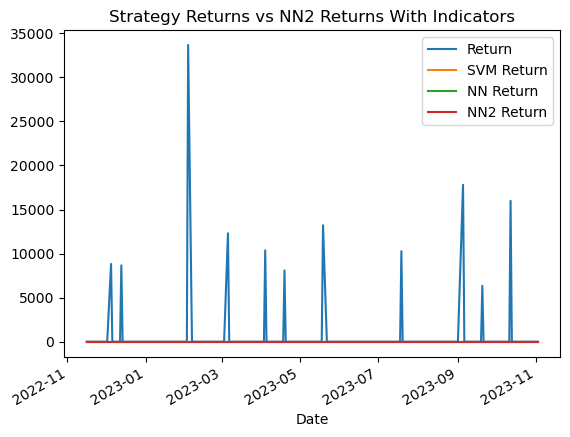

In [32]:
# Plotting the Returns
ax3 = (compare_df[["Return", "SVM Return", "NN Return", "NN2 Return"]]).plot()

# Adding a title
ax3.set_title("Strategy Returns vs NN2 Returns With Indicators")